In [2]:
import pandas as pd
import LendingClubFunctions as LC
import re
import nltk
import numpy as np
import numpy as np
import math
import datetime
import random
import dill
#coding=utf-8

In [6]:
%pylab inline
pylab.rcParams['figure.figsize']=(8.0,6.0)

Populating the interactive namespace from numpy and matplotlib


In [7]:
class Portfolio():
    '''Class object to track a portfolio of loans'''
    def __init__(self, Bank=0, StartDate=0, Equity=0):
        '''Bank is the cash portion of the portfolio, equity is the amount of money in loans'''
        self.Bank=Bank
        self.Equity=Equity
        self.Loans={}
        self.History=[]
        
        return
    
    def AddLoan(self, LoanID, Loan, NumTickets, Today):
        '''This function buys a certain number of tickets in a given loan and makes a record of it'''
        if self.Bank>NumTickets*25.:
            self.Bank-=NumTickets*25.
            self.Equity+=NumTickets*25.
            self.Loans[LoanID]={i:Loan.ix[i] for i in Loan.index}
            self.Loans[LoanID]['NumTickets']=NumTickets
            self.Loans[LoanID]['Balance']=NumTickets*25.
            if Today.month<12:
                self.Loans[LoanID]['NextPayment']=datetime.datetime(Today.year, Today.month+1, Today.day)
            else:
                self.Loans[LoanID]['NextPayment']=datetime.datetime(Today.year+1, 1, Today.day)
            
        return
    
    def UpDate(self, Today):
        '''Update the loan. Add borrower payments to the cash portion of the portfolio, remove the amount of principal 
        paid from the equity and update loan balances. If a loan is paid off early or defaults then delete it from the portfolio, remove its 
        equity and add, in the case of a repayment, its value back to the cash portion of the portfolio'''
        for Index, Loan in self.Loans.items():
            if Today>=Loan['last_pymnt_d']:
                self.Bank+=Loan['NumTickets']*Loan['LastPayMentTicket']
                self.Equity-=self.Loans[Index]['Balance']
                del self.Loans[Index]
            elif Today>=Loan['NextPayment']:
                self.Bank+=Loan['NumTickets']*Loan['TicketValue']
                
                BalanceBefore=self.Loans[Index]['Balance']
                Balance=(BalanceBefore-Loan['NumTickets']*Loan['TicketValue'])*(1+self.Loans[Index]['int_rate']/12.)
                self.Loans[Index]['Balance']=Balance
                self.Equity+=Balance-BalanceBefore
                
                if Today.month<12:
                    self.Loans[Index]['NextPayment']=datetime.datetime(Today.year, Today.month+1, Today.day)
                else:
                    self.Loans[Index]['NextPayment']=datetime.datetime(Today.year+1, 1, Today.day)
            
        self.History.append((Today, self.Bank, self.Equity, self.Bank+self.Equity))
        
        return
        
    


# Load in and clean the data

In [8]:
#Define data location
file1='./data/LoanStats3a.csv'
file2='./data/LoanStats3b.csv'
file3='./data/LoanStats3c.csv'
file4='./data/LoanStats3d.csv'
files=[file1,file2,file3,file4]
cols=['loan_amnt','funded_amnt','total_pymnt', 'loan_status', 'int_rate', 'term',
      'desc', 'grade', 'annual_inc', 'purpose', 'emp_length', 'earliest_cr_line', 
      'revol_util', 'home_ownership', 'sub_grade', 'addr_state', 'dti', 'revol_bal', 
      'installment', 'last_pymnt_d', 'issue_d', 'last_pymnt_amnt']

In [9]:
#Load data in from files
df1=LC.GetData(cols, files)
Trouble=[ 'Charged Off', 'Default', 'Does not meet the credit policy.  Status:Charged Off']
Success=['Fully Paid', 'Does not meet the credit policy.  Status:Fully Paid']
df1=LC.CleanData(df1, Success=Success, Trouble=Trouble)

/Users/admin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [128]:
SimInfo=['issue_d', 'last_pymnt_d','loan_amnt','term', 'installment' , 'last_pymnt_amnt', 'int_rate']
SimData=(df1.sort_values(by='issue_d').copy().dropna())[SimInfo]
SimData['TicketValue']=(25./SimData.loan_amnt)*SimData.installment
SimData['LastPayMentTicket']=(25./SimData.loan_amnt)*SimData.last_pymnt_amnt

# Begin Simulation

In [376]:
#The below simulates an investor starting with $10,000 at the beginning of lending club and randomly investing a random 
#amount in loan "notes", which are $25 worth of debt. We collect 100 such simlulations and average over them. 

Simulations=[]
for i in range(1000):
    LatestDate=SimData['issue_d'].iloc[-1]
    LatestDate=datetime.datetime(LatestDate.year, LatestDate.month-1, LatestDate.day)
    StartDate=SimData['issue_d'].iloc[0]
    CurrentDate=StartDate
    RandomPortfolio=Portfolio(Bank=10000, StartDate=StartDate, Equity=0)
    RandomPortfolio.UpDate(CurrentDate)
    while CurrentDate<LatestDate:
        if CurrentDate.month<12:
            CurrentDate=datetime.datetime(CurrentDate.year, CurrentDate.month+1, CurrentDate.day)
        else:
            CurrentDate=datetime.datetime(CurrentDate.year+1, 1, CurrentDate.day)

        RandomPortfolio.UpDate(CurrentDate)
        today=(SimData[SimData.issue_d==CurrentDate])
        for loan in today.index:
            if random.random()<random.random():
                NumTickets=random.randint(1,20)
                RandomPortfolio.AddLoan(loan,  today.ix[loan], NumTickets, CurrentDate)

    Simulations.append(pd.DataFrame(RandomPortfolio.History, columns=['Date', 'Cash', 'Equity', 'Total']))

    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [377]:
#This collects the results of the simulations and builds the average
Master=Simulations[0][['Date', 'Total']].copy()
Cols=['Total']
for i in range(1,len(Simulations)):
    Cols.append('Sim'+str(i))
    Master['Sim'+str(i)]=Simulations[i].Total

Master['mean']=Master[Cols].mean(axis=1) #mean
Master['std']=2.0*Master[Cols].std(axis=1)/math.sqrt(len(Cols)) #95% confidence interval

In [36]:
#I ran the above code on digital ocean. Here I'll just load in the result
f=open('Simulation.txt', 'r')
Master=dill.loads(f.read())
f.close()

<Container object of 3 artists>

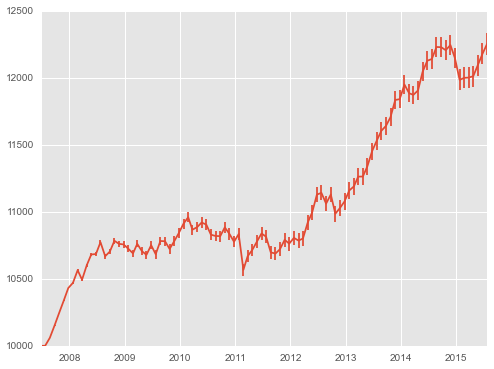

In [60]:
#Plot the mean of the simulation and a 95% confidence interval
plt.errorbar(Master.Date, Master['mean'], yerr=Master['std'])

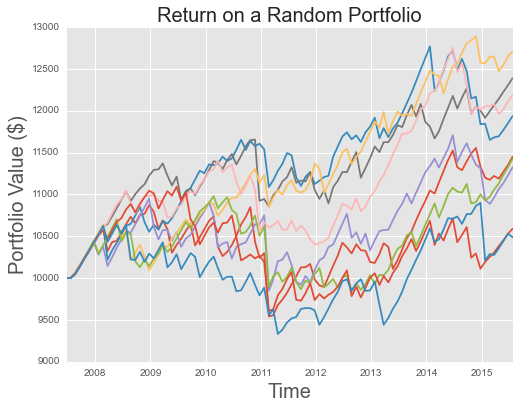

In [68]:
#plot some of the simulation results
for i in range(2,11):
    plt.plot(Master.Date,Master['Sim'+str(i)] )
plt.xlabel('Time', fontsize=20)
plt.ylabel('Portfolio Value ($)', fontsize=20)
plt.title('Return on a Random Portfolio', fontsize=20)
savefig('randomportfolio.jpg', bbox_inches='tight')

# Returns on the trained model

In [20]:
#Load model in from file
f=open('LinearModel.txt', 'r')
LinearModel=dill.loads(f.read())
f.close()

In [21]:
#Set-up for the calculation of returns for the model
SimInfo=['issue_d', 'last_pymnt_d','loan_amnt','term', 'installment' , 'last_pymnt_amnt', 'int_rate']
SimData=(df1.sort_values(by='issue_d').copy().dropna())[SimInfo]
SimData['TicketValue']=(25./SimData.loan_amnt)*SimData.installment
SimData['LastPayMentTicket']=(25./SimData.loan_amnt)*SimData.last_pymnt_amnt
features=['loan_amnt','int_rate','annual_inc','earliest_cr_line', 'revol_util','dti']

In [22]:
#Finds the return using the machine learning model. For every loan in the lending club dataset the below code goes
#through these loans chronologically and uses the machine learning model to make investment decisions. If the loan
#is expected to return 10% or more over its lifetime the model buys 10 debt notes. It invests less agressively
#when the expected return is lower and not at all if the model predicts money will be lost. 
LatestDate=SimData['issue_d'].iloc[-1]
LatestDate=datetime.datetime(LatestDate.year, LatestDate.month-1, LatestDate.day)
StartDate=SimData['issue_d'].iloc[0]
CurrentDate=StartDate
LinearPortfolio=Portfolio(Bank=10000, StartDate=StartDate, Equity=0)
LinearPortfolio.UpDate(CurrentDate)
while CurrentDate<LatestDate:
    print CurrentDate
    if CurrentDate.month<12:
        CurrentDate=datetime.datetime(CurrentDate.year, CurrentDate.month+1, CurrentDate.day)
    else:
        CurrentDate=datetime.datetime(CurrentDate.year+1, 1, CurrentDate.day)

    LinearPortfolio.UpDate(CurrentDate)
    today=(SimData[SimData.issue_d==CurrentDate])
    for loan in today.index:
        inputs=df1.ix[loan][features]
        FracReturn=LinearModel.predict(inputs)
        ExpectedReturn=FracReturn*(today.ix[loan]['term'])*(today.ix[loan]['installment'])
        if ExpectedReturn<today.ix[loan]['loan_amnt']:
            continue    
        elif ExpectedReturn>=1.1*today.ix[loan]['loan_amnt']:
            LinearPortfolio.AddLoan(loan,  today.ix[loan], 10, CurrentDate)
        elif 1.05*today.ix[loan]['loan_amnt']<ExpectedReturn<1.1*today.ix[loan]['loan_amnt']:
            LinearPortfolio.AddLoan(loan,  today.ix[loan], 5, CurrentDate)
        elif 1.01*today.ix[loan]['loan_amnt']<ExpectedReturn<1.05*today.ix[loan]['loan_amnt']:
            LinearPortfolio.AddLoan(loan,  today.ix[loan], 2, CurrentDate)
            
            

2007-06-01 00:00:00
2007-07-01 00:00:00
2007-08-01 00:00:00
2007-09-01 00:00:00
2007-10-01 00:00:00
2007-11-01 00:00:00
2007-12-01 00:00:00
2008-01-01 00:00:00
2008-02-01 00:00:00
2008-03-01 00:00:00
2008-04-01 00:00:00
2008-05-01 00:00:00
2008-06-01 00:00:00
2008-07-01 00:00:00
2008-08-01 00:00:00
2008-09-01 00:00:00
2008-10-01 00:00:00
2008-11-01 00:00:00
2008-12-01 00:00:00
2009-01-01 00:00:00
2009-02-01 00:00:00
2009-03-01 00:00:00
2009-04-01 00:00:00
2009-05-01 00:00:00
2009-06-01 00:00:00
2009-07-01 00:00:00
2009-08-01 00:00:00
2009-09-01 00:00:00
2009-10-01 00:00:00
2009-11-01 00:00:00
2009-12-01 00:00:00
2010-01-01 00:00:00
2010-02-01 00:00:00
2010-03-01 00:00:00
2010-04-01 00:00:00
2010-05-01 00:00:00
2010-06-01 00:00:00
2010-07-01 00:00:00
2010-08-01 00:00:00
2010-09-01 00:00:00
2010-10-01 00:00:00
2010-11-01 00:00:00
2010-12-01 00:00:00
2011-01-01 00:00:00
2011-02-01 00:00:00
2011-03-01 00:00:00
2011-04-01 00:00:00
2011-05-01 00:00:00
2011-06-01 00:00:00
2011-07-01 00:00:00


<Container object of 3 artists>

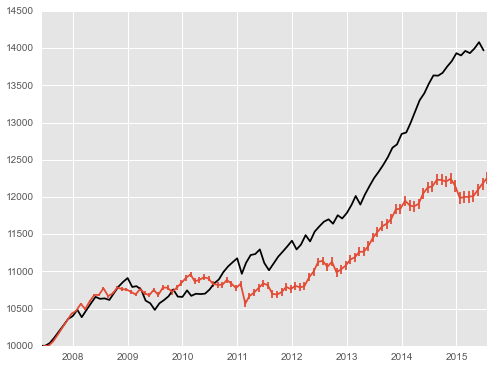

In [34]:
#Plot results of the modelled portfolio against the random portfolio
results=pd.DataFrame(LinearPortfolio.History, columns=['Date', 'Cash', 'Equity', 'Total'])
plt.plot(results.Date, results.Total, 'k' )
plt.errorbar(Master.Date, Master['mean'], yerr=Master['std'])

In [11]:
#Load model in from file
f=open('CompositeModel.txt', 'r')
CompositeModel=dill.loads(f.read())
f.close()

In [12]:
#Set-up for the calculation of returns for the model
SimInfo=['issue_d', 'last_pymnt_d','loan_amnt','term', 'installment' , 'last_pymnt_amnt', 'int_rate']
SimData=(df1.sort_values(by='issue_d').copy().dropna())[SimInfo]
SimData['TicketValue']=(25./SimData.loan_amnt)*SimData.installment
SimData['LastPayMentTicket']=(25./SimData.loan_amnt)*SimData.last_pymnt_amnt
features=['loan_amnt','int_rate','annual_inc','earliest_cr_line', 'revol_util','dti']

In [15]:
inputs=df1.ix[1]
FracReturn=CompositeModel.predictsub(inputs)[0]

In [16]:
FracReturn

0.81804193476967091

In [17]:
#Finds the return using the machine learning model. For every loan in the lending club dataset the below code goes
#through these loans chronologically and uses the machine learning model to make investment decisions. If the loan
#is expected to return 10% or more over its lifetime the model buys 10 debt notes. It invests less agressively
#when the expected return is lower and not at all if the model predicts money will be lost. 
LatestDate=SimData['issue_d'].iloc[-1]
LatestDate=datetime.datetime(LatestDate.year, LatestDate.month-1, LatestDate.day)
StartDate=SimData['issue_d'].iloc[0]
CurrentDate=StartDate
CompositePortfolio=Portfolio(Bank=10000, StartDate=StartDate, Equity=0)
CompositePortfolio.UpDate(CurrentDate)
while CurrentDate<LatestDate:
    print CurrentDate
    if CurrentDate.month<12:
        CurrentDate=datetime.datetime(CurrentDate.year, CurrentDate.month+1, CurrentDate.day)
    else:
        CurrentDate=datetime.datetime(CurrentDate.year+1, 1, CurrentDate.day)

    CompositePortfolio.UpDate(CurrentDate)
    today=(SimData[SimData.issue_d==CurrentDate])
    for loan in today.index:
        inputs=df1.ix[loan]
        FracReturn=CompositeModel.predictsub(inputs)[0]
        ExpectedReturn=FracReturn*(today.ix[loan]['term'])*(today.ix[loan]['installment'])
        if ExpectedReturn<today.ix[loan]['loan_amnt']:
            continue    
        elif ExpectedReturn>=1.1*today.ix[loan]['loan_amnt']:
            CompositePortfolio.AddLoan(loan,  today.ix[loan], 10, CurrentDate)
        elif 1.05*today.ix[loan]['loan_amnt']<ExpectedReturn<1.1*today.ix[loan]['loan_amnt']:
            CompositePortfolio.AddLoan(loan,  today.ix[loan], 5, CurrentDate)
        elif 1.01*today.ix[loan]['loan_amnt']<ExpectedReturn<1.05*today.ix[loan]['loan_amnt']:
            CompositePortfolio.AddLoan(loan,  today.ix[loan], 2, CurrentDate)
            
            

2007-06-01 00:00:00
2007-07-01 00:00:00
2007-08-01 00:00:00
2007-09-01 00:00:00
2007-10-01 00:00:00
2007-11-01 00:00:00
2007-12-01 00:00:00
2008-01-01 00:00:00
2008-02-01 00:00:00
2008-03-01 00:00:00
2008-04-01 00:00:00
2008-05-01 00:00:00
2008-06-01 00:00:00
2008-07-01 00:00:00
2008-08-01 00:00:00
2008-09-01 00:00:00
2008-10-01 00:00:00
2008-11-01 00:00:00
2008-12-01 00:00:00
2009-01-01 00:00:00
2009-02-01 00:00:00
2009-03-01 00:00:00
2009-04-01 00:00:00
2009-05-01 00:00:00
2009-06-01 00:00:00
2009-07-01 00:00:00
2009-08-01 00:00:00
2009-09-01 00:00:00
2009-10-01 00:00:00
2009-11-01 00:00:00
2009-12-01 00:00:00
2010-01-01 00:00:00
2010-02-01 00:00:00
2010-03-01 00:00:00
2010-04-01 00:00:00
2010-05-01 00:00:00
2010-06-01 00:00:00
2010-07-01 00:00:00
2010-08-01 00:00:00
2010-09-01 00:00:00
2010-10-01 00:00:00
2010-11-01 00:00:00
2010-12-01 00:00:00
2011-01-01 00:00:00
2011-02-01 00:00:00
2011-03-01 00:00:00
2011-04-01 00:00:00
2011-05-01 00:00:00
2011-06-01 00:00:00
2011-07-01 00:00:00


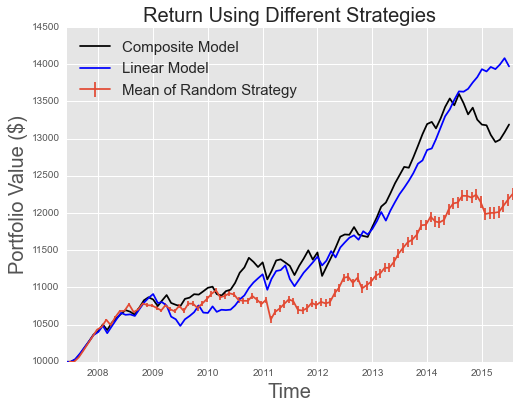

In [79]:
#Plot results of the modelled portfolio against the random portfolio
results2=pd.DataFrame(CompositePortfolio.History, columns=['Date', 'Cash', 'Equity', 'Total'])
plt.plot(results2.Date, results2.Total, 'k' ,label='Composite Model')
plt.plot(results.Date, results.Total, 'b', label='Linear Model')
plt.errorbar(Master.Date, Master['mean'], yerr=Master['std'], label='Mean of Random Strategy')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Portfolio Value ($)', fontsize=20)
plt.title('Return Using Different Strategies', fontsize=20)
plt.legend(loc='best', fontsize=15)
savefig('compareportfolio.jpg', bbox_inches='tight')